# ETTh1에 대해서 수행

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import random
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
from pytorch_forecasting.metrics import SMAPE,MAE,RMSE
from captum.attr import IntegratedGradients,NoiseTunnel

/home/sjlee/sj_virtual/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 1. 모델 구성하기
* 이전과 다르게 sequence_length를 720 즉 30일을 바라봄

In [2]:
def MSE(pred,target):
    return torch.mean((pred-target)**2,dim = 0) # reduction까지 취해줌

In [3]:
data = pd.read_csv('../../GeneralData/ETTh2.csv')
sequence_length = 720
pred_len = 1

## 2. Sequence중에 빈 시간이 없나 Check

In [4]:
import datetime as dt

In [5]:
data['date'] = pd.to_datetime(data['date'])
for i in range(data.shape[0]-1):
    if data['date'].iloc[i]+dt.timedelta(hours = 1) == data['date'].iloc[i+1]: continue        
    else: print(i)

### &rightarrow; 빈시간 없음

In [6]:
data = data[['OT']]

In [7]:
data

,OT
0,38.661999
1,37.124001
2,36.465000
3,33.608501
4,31.850500
...,...
17415,47.084999
17416,48.183498
17417,48.183498
17418,46.865501


<AxesSubplot: >

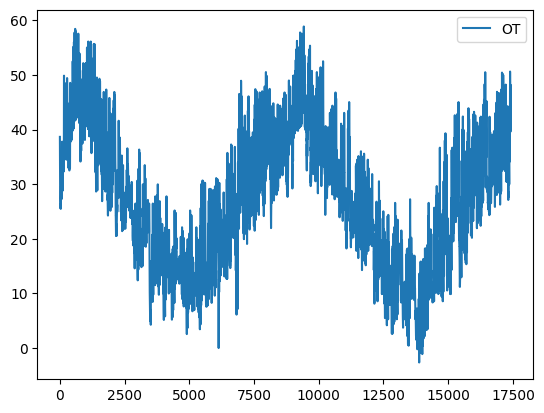

In [8]:
data.plot()

In [9]:
from torch import FloatTensor as FloatTensor

In [10]:
def seq_data(x,sequence_length,pred_len):
    seq_list = []
    target_list = []
    device = torch.device("cuda:0")
    for i in range(len(x)-sequence_length-pred_len):
        seq_list.append(x.iloc[i:i+sequence_length].values)
        target_list.append(x.iloc[i+sequence_length:i+sequence_length+pred_len].values)

    return FloatTensor(seq_list).view(-1,1,sequence_length).to(device),FloatTensor(target_list).unsqueeze(1).view(-1,1,pred_len).to(device)

In [11]:
split = 24*7 # 24시간 x 7로써 1주일을 테스트셋으로 만듦

In [12]:
seed = 42

In [13]:
device = torch.device("cuda:0")

In [14]:
class Model(nn.Module):
    def __init__(self,train_index):
        super().__init__()
        self.seq_len = len(train_index)
        self.pred_len = 1
        self.train_index = train_index
        self.first_layer = nn.Linear(self.seq_len,self.pred_len)
        self.first_layer.weight = nn.Parameter((1/self.seq_len)*torch.ones([self.pred_len,self.seq_len]))
    def forward(self,x):
        return self.first_layer(x[:,:,self.train_index]) 

# 3. Train-Validation set으로 쪼개기

In [15]:
data

,OT
0,38.661999
1,37.124001
2,36.465000
3,33.608501
4,31.850500
...,...
17415,47.084999
17416,48.183498
17417,48.183498
17418,46.865501


* 17420개 중 일주일치 데이터인 168개의 데이터를 Test Set
* 17252개 중 0.2의 비율인 3450개는 validation set
* 17252개 중 0.8의 비율인 13802개는 train set

In [16]:
val_num = 3450

In [17]:
train = data.iloc[:-split-val_num]
val = data.iloc[-split-val_num:-split]
x_train,y_train = seq_data(train, sequence_length = sequence_length, pred_len = pred_len)
x_val,y_val = seq_data(val, sequence_length = sequence_length, pred_len = pred_len)
train_dataset = TensorDataset(x_train,y_train)
val_dataset = TensorDataset(x_val,y_val)
training = DataLoader(train_dataset,batch_size=64)
validation = DataLoader(val_dataset,batch_size=64)

/tmp/ipykernel_792286/4291513198.py:9: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:230.)
  return FloatTensor(seq_list).view(-1,1,sequence_length).to(device),FloatTensor(target_list).unsqueeze(1).view(-1,1,pred_len).to(device)


In [18]:
next(iter(validation))[0].size()

torch.Size([64, 1, 720])

### 위와 같은 방식으로 validation-set에 대해서 기여도를 구하면 될 것이다.
-> 모든 batch의 각 sample에 대해서 Ig를 통한 attribution을 구해서 모든 batch에 걸쳐서 더한후 그것을 평균시킨다.<br>
-> 결과적으로 모든 validation set에 대한 attribution을 평균한다.

In [19]:
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed) # 난수 선언(원래는 cnt선언 위에 있었다)
train_index = np.arange(sequence_length)
model = Model(train_index).to(device)
optimizer = torch.optim.Adam(model.parameters(),lr=1e-4)
num_epochs = 100
n= len(training)

### 기본 모델 training

In [20]:
import copy

In [21]:
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
minimal_loss=np.inf
for epoch in range(num_epochs):  # loop over the dataset multiple times
    running_loss = 0.0
    for inputs, labels in training:
        # forward pass
        inputs = inputs
        outputs = model(inputs)
        
        outputs = outputs.view(-1,1)
        labels = labels.view(-1,1)
        
        # defining loss
        loss = MSE(outputs, labels)
        # zero the parameter gradients
        optimizer.zero_grad()
        # computing gradients
        loss.backward()
        # accumulating running loss
        running_loss += loss.item()
        # updated weights based on computed gradients
        optimizer.step()
    if epoch % 20 == 0:    
        print('Epoch [%d]/[%d] running accumulative loss across all batches: %.3f' %(epoch + 1, num_epochs, (running_loss/n)*100))
    if (running_loss/n)*100<minimal_loss:
        best_model = copy.deepcopy(model)
        minimal_loss = (running_loss/n)*100
        print("changed")

model = best_model

Epoch [1]/[100] running accumulative loss across all batches: 3219.677
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
Epoch [21]/[100] running accumulative loss across all batches: 1148.851
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
Epoch [41]/[100] running accumulative loss across all batches: 663.895
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
Epoch [61]/[100] running accumulative loss across all batches: 478.756
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
Epoch [81]/[100] running accumulative loss across all batches: 385.655
chan

### validation set에 대해서 attribution 구하기

In [22]:
n = len(validation)
n

43

In [23]:
cnt = 0
ig = IntegratedGradients(model)
nt_ig = NoiseTunnel(ig)
nt_ig_attr_score = torch.zeros((1,sequence_length))
for val in validation:
    temp_n = val[0].size(0)
    temp = nt_ig.attribute(val[0]).sum(axis = 0) # axis=0으로 batch axis를 기준으로 다 더했음
    nt_ig_attr_score = nt_ig_attr_score.to(device)+temp
    cnt = cnt + temp_n
nt_ig_attr_score = nt_ig_attr_score/cnt
nt_ig_attr_score = nt_ig_attr_score.cpu().numpy().reshape(-1)

In [24]:
len(nt_ig_attr_score)

720

<AxesSubplot: >

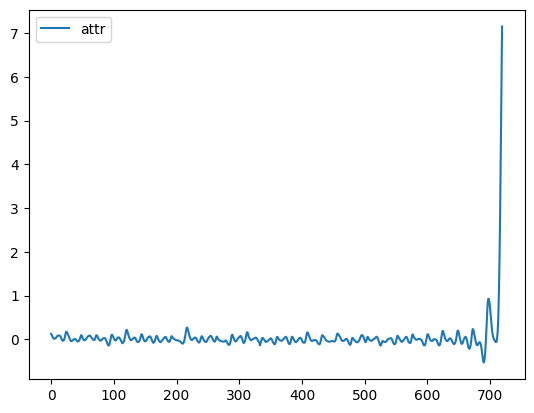

In [25]:
attr_df = pd.DataFrame({'attr':nt_ig_attr_score})
attr_df.plot()

<AxesSubplot: >

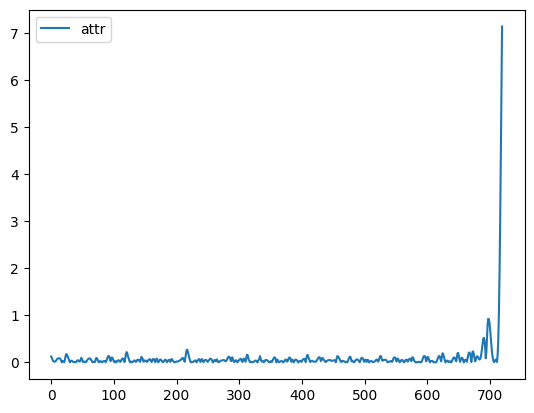

In [26]:
attr_df = attr_df.abs()
attr_df.plot()

## Outlier정의

In [27]:
IQR = 1.5*(attr_df.quantile(0.75)-attr_df.quantile(0.25))
outlier_max = attr_df.quantile(0.75)+IQR
outlier_min = attr_df.quantile(0.25)-IQR
candidate_attr = attr_df[(attr_df>=outlier_min) & (attr_df<=outlier_max)]
candidate_attr = candidate_attr.dropna()
candidate_attr

,attr
0,0.127224
1,0.100723
2,0.066671
3,0.035035
4,0.022474
...,...
707,0.019480
708,0.043038
709,0.061700
710,0.056984


<AxesSubplot: >

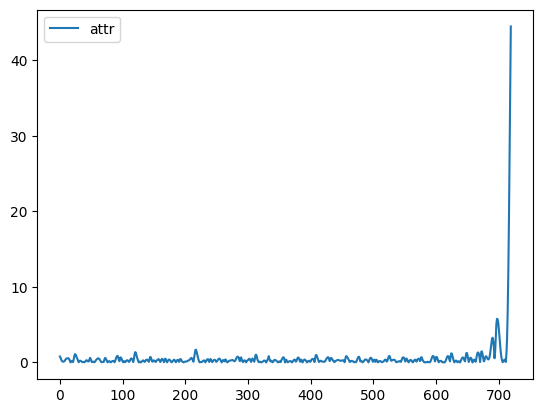

In [28]:
from sklearn.preprocessing import MinMaxScaler,StandardScaler
scaler = MinMaxScaler()
scaler.fit(candidate_attr.values)
m_attr_df = scaler.transform(attr_df.values)
m_attr_df = pd.DataFrame({"attr":m_attr_df.reshape(-1)})
# attr_df = attr_df.abs()
# attr_std = attr_df.std().item()
# attr_min = attr_df.min().item()
m_attr_df.plot()

In [29]:
m_attr_df.describe()

,attr
count,720.000000
mean,0.593856
std,2.521861
min,0.000000
25%,0.129636
50%,0.269795
75%,0.478335
max,44.483815


<AxesSubplot: >

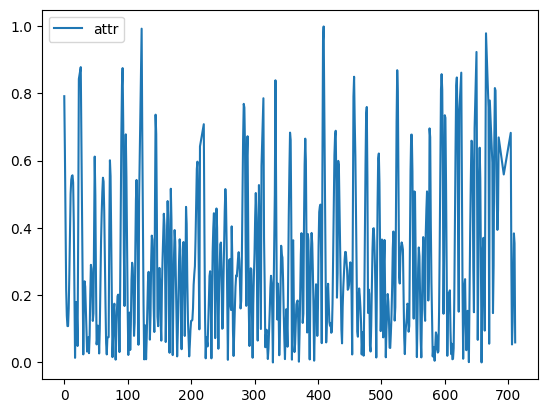

In [30]:
m_attr_df[(m_attr_df>=0) & (m_attr_df<=1)].dropna().plot()

<AxesSubplot: >

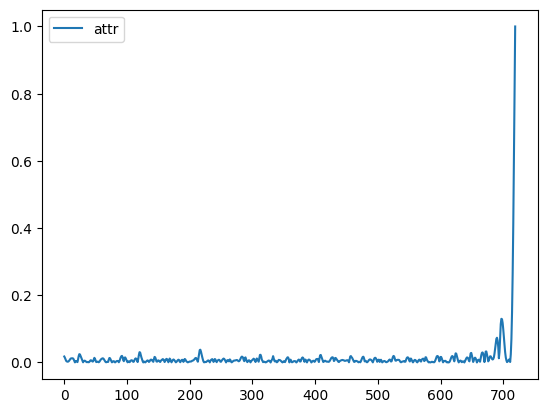

In [31]:
from sklearn.preprocessing import MinMaxScaler,StandardScaler
scaler = MinMaxScaler()
attr_df = scaler.fit_transform(attr_df.values)
attr_df = pd.DataFrame({"attr":attr_df.reshape(-1)})
# attr_df = attr_df.abs()
# attr_std = attr_df.std().item()
# attr_min = attr_df.min().item()
attr_df.plot()

#### train_index구하기

In [32]:
index_list = []

for hyper_para in np.arange(0.00,1.01,0.01):
    append_idx = list(m_attr_df[(m_attr_df['attr']>=hyper_para)].index)
    index_list.append(append_idx)
len(index_list) # train_index의 리스트

101

In [33]:
len_list=[]
for i in range(100):
    len_list.append(len(index_list[i]))


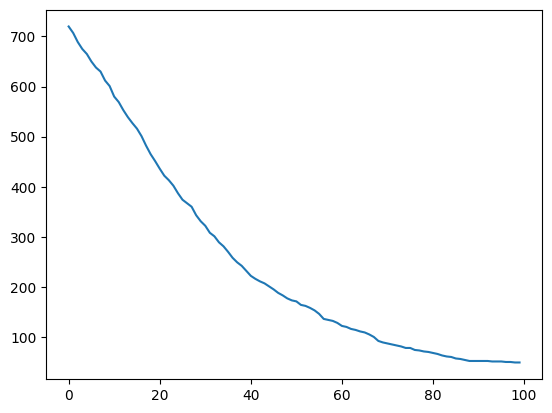

In [34]:
plt.plot(np.arange(100),len_list) # 포함되는 time_index의 갯수

In [35]:
for val_x,val_y in validation:
    print(val_x,val_y)

tensor([[[ 3.9455,  3.9455,  3.5055,  ..., 14.7120, 13.8330, 12.9540]],

        [[ 3.9455,  3.5055,  3.5055,  ..., 13.8330, 12.9540, 12.5145]],

        [[ 3.5055,  3.5055,  3.2860,  ..., 12.9540, 12.5145, 12.0750]],

        ...,

        [[ 8.9990,  8.7795,  7.6805,  ..., 16.6890, 16.9090, 17.7880]],

        [[ 8.7795,  7.6805,  6.5820,  ..., 16.9090, 17.7880, 18.2275]],

        [[ 7.6805,  6.5820,  5.2640,  ..., 17.7880, 18.2275, 19.3265]]],
       device='cuda:0') tensor([[[12.5145]],

        [[12.0750]],

        [[11.1965]],

        [[10.7570]],

        [[10.3175]],

        [[10.0980]],

        [[10.7570]],

        [[12.9540]],

        [[16.4700]],

        [[19.3260]],

        [[22.4025]],

        [[24.3800]],

        [[26.1375]],

        [[27.8955]],

        [[27.4560]],

        [[25.9180]],

        [[23.9405]],

        [[22.1825]],

        [[20.4250]],

        [[19.3260]],

        [[18.2275]],

        [[17.3485]],

        [[16.9090]],

        [[16.9090]

       device='cuda:0') tensor([[[35.1220]],

        [[34.4630]],

        [[34.0235]],

        [[33.5840]],

        [[33.3645]],

        [[32.9245]],

        [[32.7050]],

        [[32.2655]],

        [[31.8260]],

        [[31.3865]],

        [[29.1895]],

        [[28.0905]],

        [[27.6515]],

        [[27.6515]],

        [[26.7725]],

        [[26.5530]],

        [[27.6515]],

        [[29.1895]],

        [[30.2880]],

        [[30.9475]],

        [[32.0455]],

        [[32.0455]],

        [[32.4855]],

        [[32.2655]],

        [[32.0460]],

        [[31.8260]],

        [[30.7275]],

        [[30.0685]],

        [[29.6290]],

        [[28.9695]],

        [[28.5305]],

        [[28.3105]],

        [[27.8710]],

        [[27.6515]],

        [[27.2120]],

        [[26.9925]],

        [[26.9925]],

        [[26.9925]],

        [[28.5305]],

        [[31.1665]],

        [[34.2430]],

        [[38.6380]],

        [[40.3955]],

        [[42.1530]],

        

In [36]:
val_x

tensor([[[31.3620, 31.3620, 30.7030,  ..., 38.3445, 37.9055, 37.4660]],

        [[31.3620, 30.7030, 30.2635,  ..., 37.9055, 37.4660, 37.0265]],

        [[30.7030, 30.2635, 29.3850,  ..., 37.4660, 37.0265, 36.1475]],

        ...,

        [[28.5060, 28.0665, 27.6270,  ..., 41.6410, 40.9815, 36.8070]],

        [[28.0665, 27.6270, 26.5285,  ..., 40.9815, 36.8070, 36.3670]],

        [[27.6270, 26.5285, 26.5285,  ..., 36.8070, 36.3670, 34.1700]]],
       device='cuda:0')

In [37]:
### 원래 난수가 선언된 위치
m = len(validation)
n = len(training)
cnt = 0
num_epochs = 100
mse_out_list = []
mae_out_list = []
smape_out_list = []
rmse_out_list = []
for idx in index_list: #0.01~1.00 100개의 index에 대해서 수행
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed) # 난수 선언(원래는 cnt선언 위에 있었다)
    train_idx = idx
    minimal_loss=np.inf
    model = Model(train_idx).to(device) # 모델 초기화
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4) # optimizer 초기화
    result = 0
    for epoch in range(num_epochs):  # loop over the dataset multiple times
        running_loss = 0.0
        for inputs, labels in training:
            # forward pass
            inputs = inputs
            
            outputs = model(inputs)
            outputs = outputs.view(-1,1)
            labels = labels.view(-1,1)            
            # defining loss
            loss = MSE(outputs, labels)
            # zero the parameter gradients
            optimizer.zero_grad()
            # computing gradients
            loss.backward()
            # accumulating running loss
            running_loss += loss.item()
            # updated weights based on computed gradients
            optimizer.step()
        if epoch == 99:    
            print(f'{cnt}번째 모델 Training 완료 마지막 Epoch loss:{(running_loss/n)*100}')
        
        if (running_loss/n)*100<minimal_loss:
            best_model = copy.deepcopy(model)
            minimal_loss = (running_loss/n)*100
            print("changed")

    model = best_model
    cnt+=1
    # 모델 Fully-Training 완료
    
    pred = torch.FloatTensor().to(device)
    val_target = torch.FloatTensor().to(device)
    for val_x,val_y in validation:
        tmp_pred = model(val_x)
        pred = torch.concat([pred,tmp_pred], dim=0)
        val_target = torch.concat([val_target,val_y],dim = 0)
    pred = pred.view(-1,1)
    val_target = val_target.view(-1,1)
    result = MSE(pred,val_target).item()
    mse_out_list.append(result)
    mae_out_list.append(MAE()(pred,val_target).item())
    rmse_out_list.append(RMSE()(pred,val_target).item())
    smape_out_list.append(SMAPE()(pred,val_target).item()*100)

changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
0번째 모델 Training 완료 마지막 Epoch loss:332.8500157740058
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
chan

changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
9번째 모델 Training 완료 마지막 Epoch loss:307.2077817160909
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
chan

changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
19번째 모델 Training 완료 마지막 Epoch loss:281.2010759260597
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
cha

changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
28번째 모델 Training 완료 마지막 Epoch loss:266.4339103349825
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
29번째 모델 Training 완료 마지막 Epoch loss:265.6503991528255
change

changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
38번째 모델 Training 완료 마지막 Epoch loss:268.0799992346182
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
cha

changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
48번째 모델 Training 완료 마지막 Epoch loss:257.6207034980378
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
cha

changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
57번째 모델 Training 완료 마지막 Epoch loss:238.2237890435428
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
cha

changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
67번째 모델 Training 완료 마지막 Epoch loss:228.43695868806142
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
ch

changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
76번째 모델 Training 완료 마지막 Epoch loss:220.9770634116196
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
77번째 모델 Training 완료 마지막 Epoch loss:226.11796083973675
changed
chang

changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
86번째 모델 Training 완료 마지막 Epoch loss:220.8536283417446
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
cha

changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
96번째 모델 Training 완료 마지막 Epoch loss:227.2078592312045
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
cha

In [38]:
val_y # 다음 예측 타겟값

tensor([[[37.0265]],

        [[36.1475]],

        [[35.7080]],

        [[35.0485]],

        [[34.8290]],

        [[34.8290]],

        [[35.9280]],

        [[37.9055]],

        [[40.1025]],

        [[44.0575]],

        [[46.4750]],

        [[47.1340]],

        [[46.6945]],

        [[48.2325]],

        [[47.5730]],

        [[46.0350]],

        [[44.9365]],

        [[43.8380]],

        [[43.1785]],

        [[42.3000]],

        [[41.4210]],

        [[40.7620]],

        [[40.3220]],

        [[39.8830]],

        [[39.4430]],

        [[39.2235]],

        [[38.7840]],

        [[37.9055]],

        [[37.4660]],

        [[37.4660]],

        [[38.1250]],

        [[39.8830]],

        [[41.2010]],

        [[41.6410]],

        [[41.6410]],

        [[41.6410]],

        [[40.9815]],

        [[36.8070]],

        [[36.3670]],

        [[34.1700]],

        [[32.1925]]], device='cuda:0')

In [39]:
val_x # 예측 하는 값

tensor([[[31.3620, 31.3620, 30.7030,  ..., 38.3445, 37.9055, 37.4660]],

        [[31.3620, 30.7030, 30.2635,  ..., 37.9055, 37.4660, 37.0265]],

        [[30.7030, 30.2635, 29.3850,  ..., 37.4660, 37.0265, 36.1475]],

        ...,

        [[28.5060, 28.0665, 27.6270,  ..., 41.6410, 40.9815, 36.8070]],

        [[28.0665, 27.6270, 26.5285,  ..., 40.9815, 36.8070, 36.3670]],

        [[27.6270, 26.5285, 26.5285,  ..., 36.8070, 36.3670, 34.1700]]],
       device='cuda:0')

In [40]:
result/68

0.049447105211370135

In [41]:
val_x.size()

torch.Size([41, 1, 720])

         out
87  3.292634


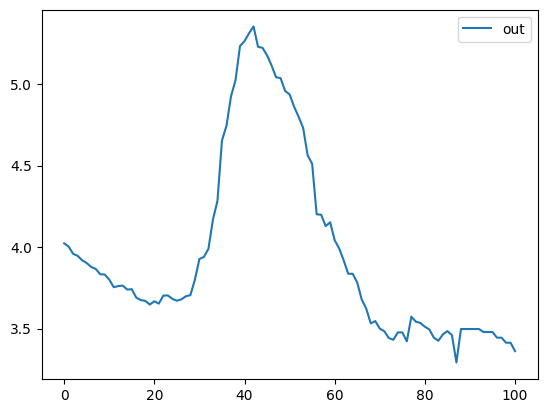

In [42]:
out_df = pd.DataFrame({"out":mse_out_list})

out_df.plot()

print(out_df[out_df['out']==out_df['out'].min()])

In [43]:
out_df

,out
0,4.023090
1,4.002983
2,3.958587
3,3.946331
4,3.919005
...,...
96,3.444688
97,3.444688
98,3.413723
99,3.413723


         out
87  1.386915


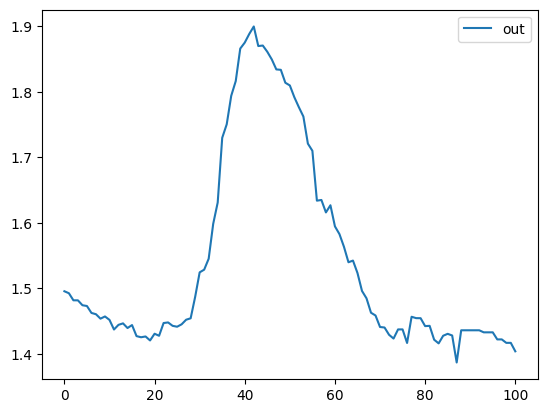

In [44]:
out_df = pd.DataFrame({"out":mae_out_list})

out_df.plot()

print(out_df[out_df['out']==out_df['out'].min()])

In [45]:
out_df

,out
0,1.495614
1,1.492577
2,1.481802
3,1.481732
4,1.474292
...,...
96,1.422133
97,1.422133
98,1.416863
99,1.416863


         out
87  5.292909


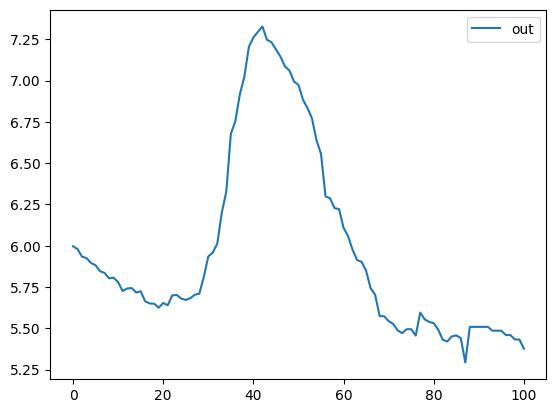

In [46]:
out_df = pd.DataFrame({"out":smape_out_list})

out_df.plot()

print(out_df[out_df['out']==out_df['out'].min()])

In [47]:
out_df

,out
0,5.996296
1,5.979610
2,5.933478
3,5.924900
4,5.894899
...,...
96,5.458990
97,5.458990
98,5.432146
99,5.432146


         out
87  1.814561


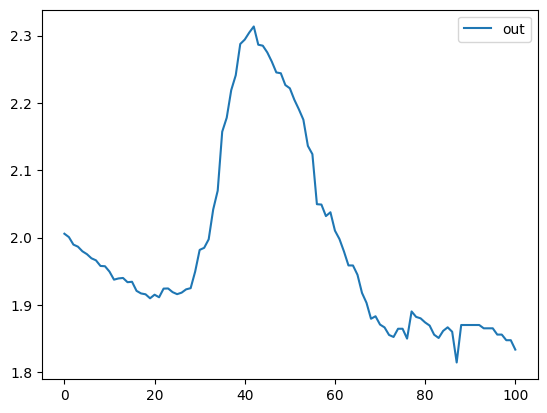

In [48]:
out_df = pd.DataFrame({"out":rmse_out_list})

out_df.plot()

print(out_df[out_df['out']==out_df['out'].min()])

In [49]:
out_df

,out
0,2.005764
1,2.000746
2,1.989620
3,1.986537
4,1.979648
...,...
96,1.855987
97,1.855987
98,1.847626
99,1.847626


In [50]:
attr_df.describe()

,attr
count,720.000000
mean,0.013350
std,0.056692
min,0.000000
25%,0.002914
50%,0.006065
75%,0.010753
max,1.000000
